# Assessing Landcover Classification Performance

In [14]:
data_filepath = str(u"C:\\Users\\Alison Link\\Documents\\INET4710\\FinalProjectData\\")

train_images = [
    ['TRAIN',
        data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TRAIN.tif', # just west of downtown St. Paul (by St. Paul campus)  
        data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TRAIN.tif'
    ]
]

test_images = [
    ['TEST0',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST0.tif', # downtown Minneapolis
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST0.tif'
    ],
    ['TEST1',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST1.tif', # just east of downtown Minneapolis
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST1.tif'
    ],
    ['TEST2',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST2.tif', # downtown St. Paul
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST2.tif'
    ]
]

### NDVI accuracy assessment

We can start with a quick and dirty version of an accuracy assessment that simply looks at the question: _Did the modeling process help us accurately discern the difference between vegetation and non-vegetation land use classes?_  We can address this question by grouping together NDVI-postive NDVI-negative land use classes from both the training/test data and the "ground truth" comparison data, and seeing where they overlap.  

The function below compares pixels from the train/test images with the corresponding pixels from the "ground truth" images and identifies pixels where the NDVI values do not align.  The dictionary mapping below indicates which classification numbers from each of the datasets are associated with vegetation (NDVI-positive) and non-vegetation (NDVI-negative) for the purpose of assessing alignment.

In [52]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dictionary to map which classes are NDVI positive and which are negative in the training and 
# "ground truth" data
ndvi_dict = {
    'train_test_ndvi_pos': [1, 2, 3],
    'gt_ndvi_pos': [1, 6, 7, 8, 9, 10],
    'train_test_ndvi_neg': [0, 4, 5, 6],
    'gt_ndvi_neg': [2, 3, 4, 5, 11, 12]
}

def calculate_ndvi_classification_performance(img_sets, ndvi_dict):
    ''' Does the model discern correctly between pixels that are NDVI + and NDVI - ? 
    Take image sets as an input (with the target image first, and the ground truth 
    comparison image second).  Compare where they match and where they don't. '''
    
    fig, axs = plt.subplots(1, len(img_sets), figsize=(20, 5))
    
    for i in range(len(img_sets)):
        classified_img = rasterio.open(img_sets[i][1])
        gt_img = rasterio.open(img_sets[i][2])

        classification = classified_img.read(1).astype('int')
        gt_class = gt_img.read(1).astype('int')

        ndvi_classification_accuracy = np.empty(classified_img.shape, dtype=rasterio.int8)
        ndvi_classification_accuracy = np.where(
            np.logical_or(np.logical_and(np.isin(classification, ndvi_dict['train_test_ndvi_pos']), 
                                         np.isin(gt_class, ndvi_dict['gt_ndvi_pos'])),
                          np.logical_and(np.isin(classification, ndvi_dict['train_test_ndvi_neg']), 
                                         np.isin(gt_class, ndvi_dict['gt_ndvi_neg']))) , 1, 0) # 1 if they match, 0 if they don't

        accuracy_pct = round((np.sum(ndvi_classification_accuracy) / classification.size) * 100, 3) 
        
        axs[i].imshow(ndvi_classification_accuracy)
        axs[i].set_title(img_sets[i][0] + ": NDVI classification accuracy = " + str(accuracy_pct))

Looking at the output below, we see that, in general, the NDVI misclassification seems to occur on the boundaries of objects, where one land use class bumps up against another.  This is not entirely surprising, as these are the regions where there is some genuine ambiguity: pixels themselves--particularly in liminal regions between classes--are not "pure" representations of substances, and instead represent a "mixing" of reflectance from the earth's surface before it hits a sensor and is encoded back into discretized pixel units.  The remote sensing literature is full of references to the conundrums of "spectral unmixing", which is an unavoidable phenomenon in remotely sensed imagery (see: Ma, et al., 2014; Keshava & Mustard, 2002). Because of this, a bit of misclassification "noise" around the edges of land use classes should not be overly concerning to us.  In fact, the accuracy we see here is particularly impressive when we consider that the classifications we're comparing were derived from vastly different methodologies--the "ground truth" data representing an object-based image analysis approach, compared to the unsupervised pixel-by-pixel NMF-based classification approach.

There are a few regions where the misclassifications appear more systematic.  For example, there is a region in the upper left corner of the training image where there are several large, misclassified areas.  Examining this discrepancy in a GIS reveals that this is likely due to annual change in agricultural growth that is not represented in the "ground truth" comparison data.  The "ground truth" dataset classifies this region as agricultural land, but at the time when the training image was captured, this land happend to be lying fallow.  In some respect, then, the NMF model was actually "more" correct in its classification than the "ground truth": the model classified this land as dirt/soil, which happened to be more true to the state of the land at the time of image capture!  There also appears to be some systematic inaccuracy in the lower left-hand corner of the first test image.  Examining this region in a GIS reveals that the "ground truth" data is classifying this area as a lake/pond, while the NMF model is labeling this as field/turf.  This could be due to some kind of algae growth or lake bed plant growth that is reflecting in this region.  Again, it seems likely that the NMF model is actually _more_ correct, and provides some additional nuance that "ground truth" dataset has obscured.

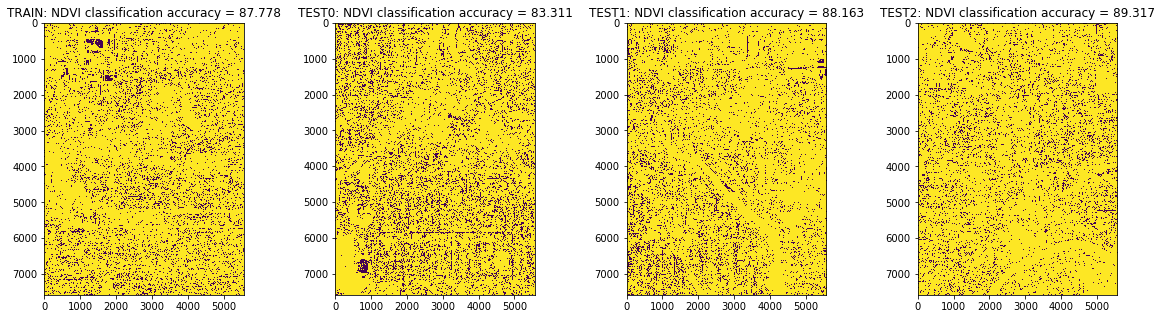

In [16]:
calculate_ndvi_classification_performance(train_images + test_images, ndvi_dict)

### Class-by-class accuracy assessment

Note that we need to skip one of the classes (class 2), as the ground truth data does not separate this class

In [71]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Dictionary to map categories for comparison between train/test classification comparable values in the 
# "ground truth" data
classification_compare_dict = {
    0: ['water', [5, 9, 10, 11]], # water features
    1: ['grass/agriculture', [1, 8]], # grass (and agriculture)
    #2: # artificial turf
    3: ['trees', [6, 7]], # trees
    4: ['dirt/soil', [2, 12]], # dirt
    5: ['asphalt/buildings', [3, 4]], # asphalt/buildings
    6: ['sand/soil', [2, 12]] # sand & light roofs
}

def calculate_classification_performance(img_sets, classification_compare_dict):
    
    fig, axs = plt.subplots(len(img_sets), len(classification_compare_dict), figsize=(20, 5 * len(img_sets)), squeeze=False)
    
    for i in range(len(img_sets)):
        classified_img = rasterio.open(img_sets[i][1])
        gt_img = rasterio.open(img_sets[i][2])

        classification = classified_img.read(1).astype('int')
        gt_class = gt_img.read(1).astype('int')

        misclassification_rates = []

        for j, class_label in enumerate(classification_compare_dict.keys()):

            gt_class_pixels = np.where(np.isin(gt_class, classification_compare_dict[class_label][1]), 1, 0)
            #print(gt_class_pixels)
            
            misclassified_pixels = np.where(np.logical_and(
                np.isin(gt_class, classification_compare_dict[class_label][1]), # find areas where the ground truth is class j
                np.not_equal(classification, class_label)), # look for where the classified image does not align
                                            1, 0)

            accuracy_pct = round(100 - ((np.sum(misclassified_pixels) / np.sum(gt_class_pixels)) * 100), 3)
            gt_colors = ListedColormap(['white', 'black'])
            axs[i][j].imshow(gt_class_pixels, cmap=gt_colors)
            
            misclass_colors = ListedColormap(['white', 'orangered'])
            axs[i][j].imshow(misclassified_pixels, cmap=misclass_colors, alpha=.5)
            
            axs[i][j].set_title(img_sets[i][0] + ": Class " + str(class_label) + " (" + classification_compare_dict[class_label][0] + ")" + "\nAccuracy = " + str(accuracy_pct))

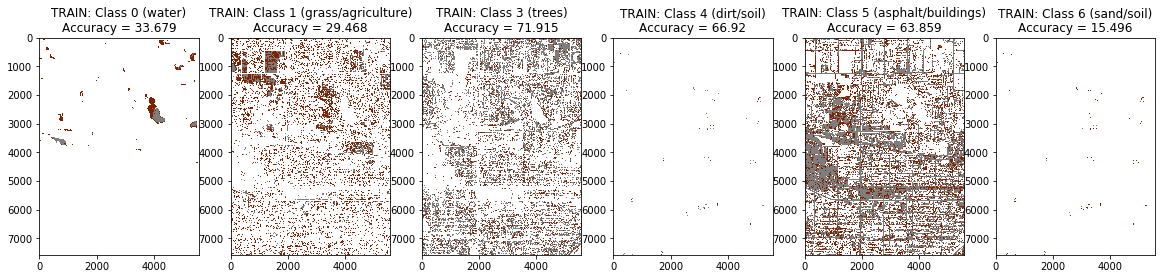

In [72]:
calculate_classification_performance(train_images, classification_compare_dict)

## Conclusions

Pros of unsupervised NMF landcover classifiation approach:

* 


Cons of unsupervised NMF landcover classification approach:
    
* Cannot easily distinguish between buildings and roads.

* Requires some judgement on the part of the user to decide where to set the NDVI water cutoff threshold for what should be considered water prior to training the model.  The NDVI water cutoff threshold is a hyperparameter that can vary a bit based on the quality of the image and the atmospheric/reflectance conditions on the day the image was captured.

* May "learn" classes that, while they are distinct enough to justifiably be separated, are not particularly meaningful to humans.  (For example: Separating red/clay roofs from other building roofs.)

* Is a raster-based, pixel-by-pixel analysis.  Does not segment out vectorized "objects" that are often useful in land use analysis.  Would need to look into how to combine this with segmentation algorithms--likely _after_ the classification model has been applied to new data--to extract vectorized "objects" with certain landcover classifiations from the image.